We are going to trick VGG19 thanks to advers

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt
import PIL

Let's load one of the most famous networks VGG19

In [2]:
model_name = 'vgg19'
vgg_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
vgg_model.eval()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # these values are taken from the vgg19 dataset
])

def format_image(img_file):
	"""
	This function reads and formats an image so that it can be fed to the VGG16 networks

 """
	img = PIL.Image.open(img_file)
	img_tensor = normalise_resize(img).unsqueeze(axis=0)
	img_np = np.array(img)

	return img_tensor, img_np

def unformat_image(img_in):
	"""
	This function inverts the preprocessing applied to images for use in the VGG19 network

	"""
	img_in = np.transpose(img_in.detach().numpy().squeeze(),[1,2,0])
	# invert the mean and standard deviation
	mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
	std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
	img_out = std * img_in + mean
	img_out *= 255
	img_out = np.uint8(np.clip(img_out, 0, 255))
	return img_out

In [3]:
def vector_to_class(x):
  "function that returns a index of a class, from a vector "

  act = torch.nn.Softmax()
  y = torch.tensor([torch.argmax(act(t)) for t in x])
  return y

In [7]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1S0a4DMw3McQ0CJ9rQssJaYIOeuUvCoHo' -O cat_small.png
img_in,img_visu = format_image('cat_small.png')

will be placed in the single file you specified.

--2024-02-08 14:20:09--  https://drive.google.com/uc?export=download&id=1S0a4DMw3McQ0CJ9rQssJaYIOeuUvCoHo
Resolving drive.google.com (drive.google.com)... 74.125.137.100, 74.125.137.102, 74.125.137.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.137.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1S0a4DMw3McQ0CJ9rQssJaYIOeuUvCoHo&export=download [following]
--2024-02-08 14:20:09--  https://drive.usercontent.google.com/download?id=1S0a4DMw3McQ0CJ9rQssJaYIOeuUvCoHo&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160840 (157K) [image/png]
Saving to: ‘cat_small.png’

cat_small.png       100%[========

Below this cell, this our cat, we are going to trick vgg19 into thinking it is a camera or whatever class that we want by a tiny adjustment

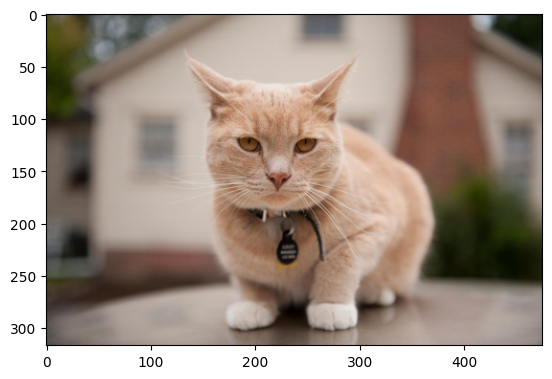

In [9]:
plt.imshow(img_visu)


First, we find the initial class of the cat image (which we consider to be the true class). Here, we have downloaded the imagenet label list to convert a class number to a string (name of the class).

In [10]:
# get the image net class names
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1_gCkMzvywUVzi9P7xZjcETShc3bqBv9T' -O imagenet1000_clsidx_to_labels.txt
imagenet_labels = np.array(open("imagenet1000_clsidx_to_labels.txt").read().splitlines())

target_class = 759

#define the true class as the initial most likely class
true_class = vector_to_class(vgg_model(img_in)) # FILL IN STUDENT CODE
true_class_name = imagenet_labels[true_class]
print("True class : ", true_class_name)

will be placed in the single file you specified.

--2024-02-08 14:25:13--  https://drive.google.com/uc?export=download&id=1_gCkMzvywUVzi9P7xZjcETShc3bqBv9T
Resolving drive.google.com (drive.google.com)... 142.251.2.100, 142.251.2.138, 142.251.2.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1_gCkMzvywUVzi9P7xZjcETShc3bqBv9T&export=download [following]
--2024-02-08 14:25:13--  https://drive.usercontent.google.com/download?id=1_gCkMzvywUVzi9P7xZjcETShc3bqBv9T&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [application/octet-stream]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imag

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [11]:
print("True class : ", true_class_name)

True class :   285: 'Egyptian cat',


We must define the gradient step function for finding the adversarial example. It now takes the target_class instead of the list of layer indices to maximise.

In [14]:
def adversarial_example_gradient_step(img_in, model_in, target_class, step_size):

	mean = torch.tensor([0.485, 0.456, 0.406]).reshape([3, 1, 1])
	std = torch.tensor([0.229, 0.224, 0.225]).reshape([3, 1, 1])

	activations = []
	losses = []

	x = img_in
	# First, we fetch the activation of the model, when applied to img_in
	activations = torch.nn.Softmax()(model_in(x))

  #compute the loss
	final_loss = activations[0][target_class]

	# Carry out backpropagation
	final_loss.backward()

	# get gradients of loss function with respect to the image
	grad = img_in.grad.data

	# Normalize the gradients (make them have mean = 0 and std = 1)
	g_std = torch.std(grad)
	g_mean = torch.mean(grad)
	grad -= g_mean
	grad /= 1e-8 + g_std

	# Update image using the calculated gradients (gradient ascent step)
	img_in.data += grad*step_size

	# Reset the grad data in img_in to zero
	img_in.grad.data.zero_()

	# We clamp the data to avoid going too far from the VGG normalisation
	img_in.data = torch.clip(img_in, -mean / std, (1 - mean) / std)

	return img_in, final_loss


We are now ready to trick vgg the image such that we misclassify it.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


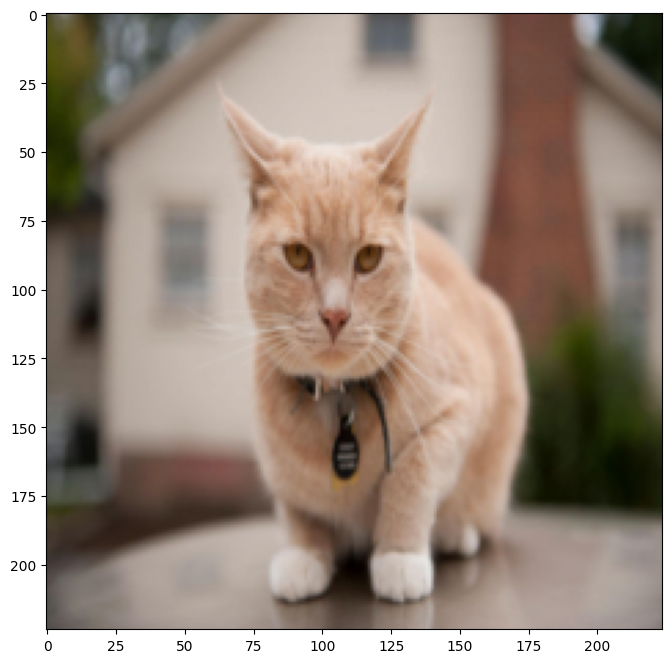

Current class :  285: 'Egyptian cat', with probability : 0.6316
.

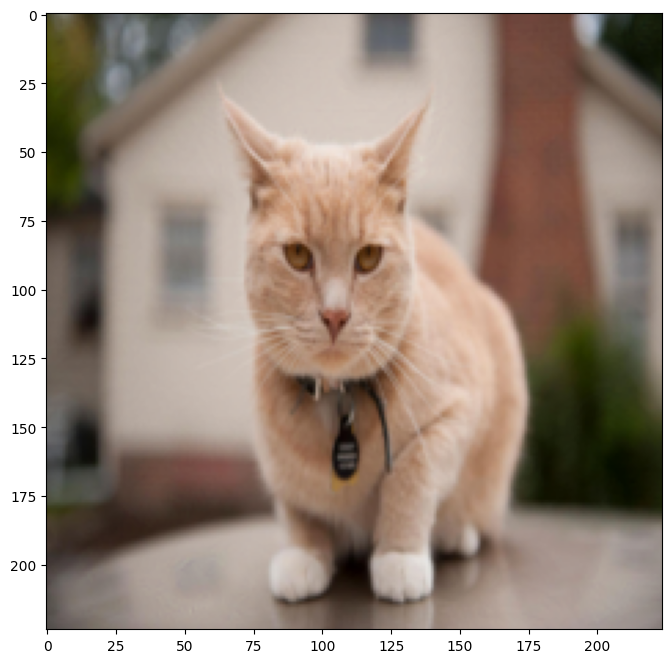

Current class :  622: 'lens cap, lens cover', with probability : 0.1016


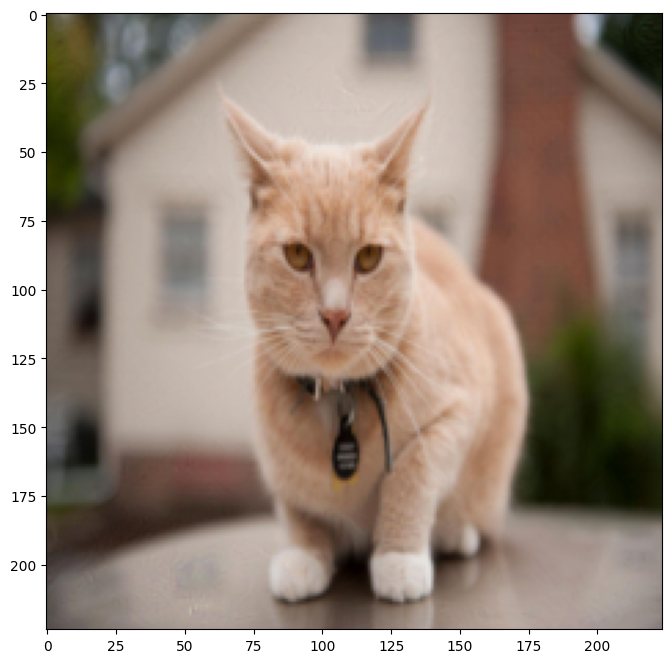

Current class :  622: 'lens cap, lens cover', with probability : 0.1399


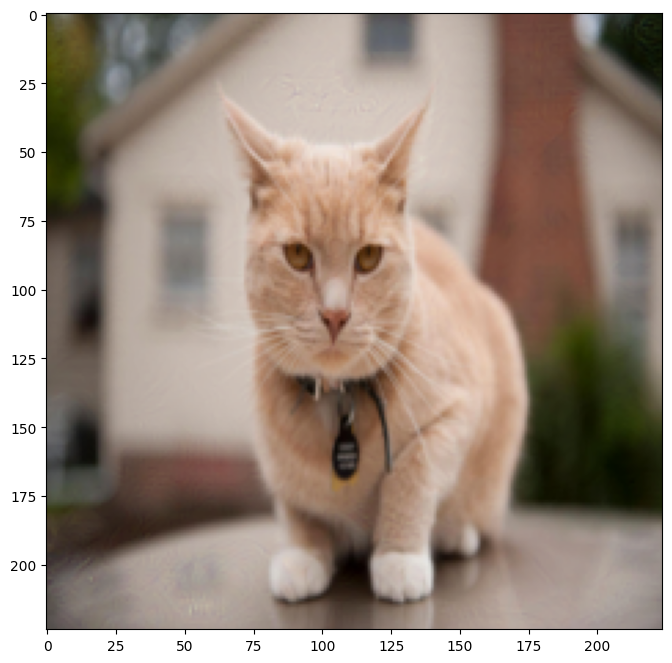

Current class :  622: 'lens cap, lens cover', with probability : 0.2288


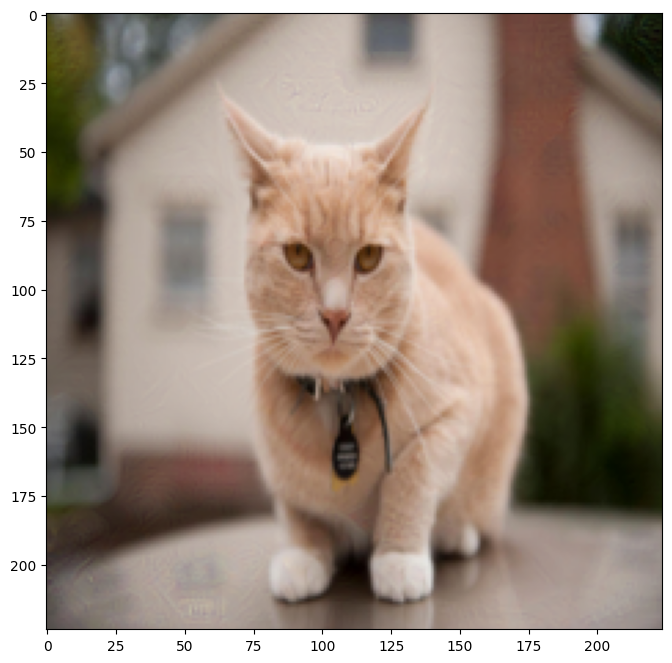

Current class :  759: 'reflex camera', with probability : 0.3331


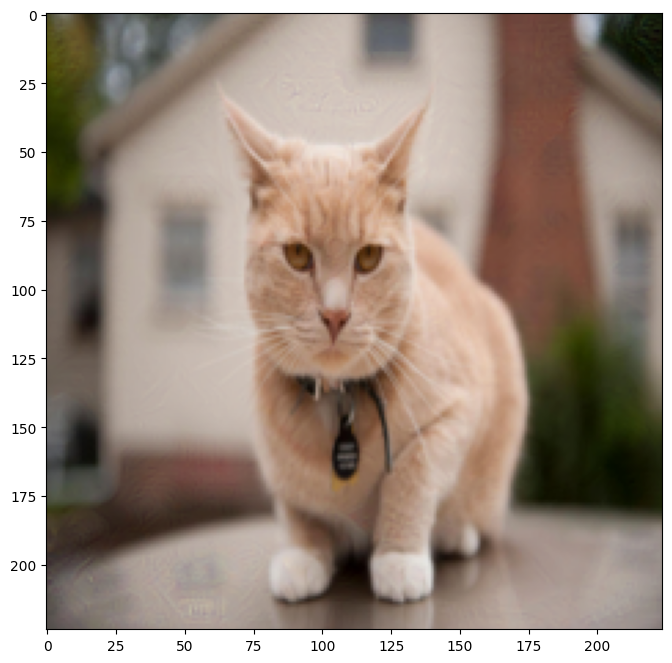

In [16]:

img_in,_ = format_image('cat_small.png')


step_size = 0.01 # Gradient ascent step size


current_class = int(vector_to_class(vgg_model(img_in)))
current_class_name = imagenet_labels[current_class]
target_class = 759 # change this line if we want to trick with an other class
target_class_name = imagenet_labels[target_class]

plt.figure(num=None, figsize=(10, 8))
img_out = unformat_image(torch.clone(img_in))
plt.imshow(img_out)
plt.show()
print("Current class : {} with probability : {:.4f}".format(current_class_name, torch.nn.Softmax(dim=1)(vgg_model(img_in))[0,current_class]))
print(".", end='')

img_in.requires_grad = True
while target_class != current_class :
  img_in, loss = adversarial_example_gradient_step(img_in, vgg_model, target_class, step_size) # FILL IN STUDENT
  #get the current class
  current_class = vector_to_class(vgg_model(img_in))
  current_class_name = imagenet_labels[current_class]
  plt.figure(num=None, figsize=(10, 8))
  img_out = unformat_image(img_in)
  plt.imshow(img_out)
  plt.show()
  print("Current class : {} with probability : {:.4f}".format(current_class_name, torch.nn.Softmax(dim=1)(vgg_model(img_in))[0,current_class].item()))

    #plt.imsave('img_out_'+str(ii).zfill(3)+'.png',img_out)

img_out = unformat_image(img_in)
plt.figure(num=None, figsize=(10, 8))
plt.imshow(img_out)
plt.show()

Our egyptian cat has been misclassified as a reflex camera